### Import Libs and Initializations

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from typing import Union, Any, Dict
import ipywidgets as widgets
from tqdm.notebook import tqdm
from utils import tiffread_utils, fft_funcs, glen_funcs
import itertools
import multiprocessing


# currently unused
# import itertools
# import pickle
# import random


In [27]:
# bathy_dict = tiffread_utils.load_file(filename='BlueTopo_BH5245GN_20230804.tiff', 
#                        folder='seafloor_files', 
#                        verbose=False)
# depth = tiffread_utils.remove_edge_Nans(depth=bathy_dict['depth'], ndv=bathy_dict['ndv'])



# resolution = bathy_dict['resolution']
# desired_linespacing_meters = 515
# multiples = [1, 2, 4]
# max_multiple = 1
# column_indices = fft_funcs.get_column_indices(array_len=depth.shape[1], 
#                                     resolution=resolution, 
#                                     linespacing_meters=desired_linespacing_meters, 
#                                     max_multiple= max_multiple,
#                                     verbose=False)

# column_ranges = list(zip(column_indices[:-1], column_indices[1:]))

# # selection = 'index'
# selection = 'half'

# # create placeholder for output
# output = np.zeros_like(depth)
# output[:] = np.nan
# output2 = output.copy()
# residuals = output.copy()


# # for data strip, dimension is the same as linespacing so multiple=1
# for col_range in column_ranges:
#     segment_data = fft_funcs.get_strip(depth, column_indices=col_range, multiple=1, verbose=False)
#     residual_data, interpolated  = fft_funcs.compute_residual(segment_data, verbose=False)
#     # print(f"residual_data shape: {residual_data.shape}")
#     # window_data = get_strip(depth, column_indices=col_range, multiple=max_multiple, verbose=False, row=row)
#     # residual_data2, interpolated2 = get_interpolation_residual(window_data, verbose=False)
#     residuals[:, col_range[0]:col_range[1]+1] = residual_data
#     output[:, col_range[0]:col_range[1]+1] = np.apply_along_axis(glen_funcs.glen_get_uncertainties, axis=1, 
#                                                                  arr=residual_data, 
#                                                                  resolution=resolution, 
#                                                                  multiple=max_multiple,
#                                                                  method='psd')
#     output2[:, col_range[0]:col_range[1]+1] = np.apply_along_axis(fft_funcs.compute_fft_uncertainty, 
#                                                                 axis=1, arr=residual_data, 
#                                                                 multiple = max_multiple,
#                                                                 resolution=resolution, 
#                                                                 windowing='hann', 
#                                                                 method = 'spectrum',
#                                                                 selection = selection)
    
# fail_points_francis, errors_francis = glen_funcs.uncertainty_comparison(residuals, output2)
# fail_points_glen, errors_glen = glen_funcs.uncertainty_comparison(residuals, output)



# def simulate_uncertainty(filenames:list[str], linespacing:list[int], methods:list[str], multiples:list[int]):
#     for fn in tqdm(filenames):
#         # read bathymetric file and extract metadata
#         bathy_dict = tiffread_utils.load_file(filename=fn, 
#                         folder='../../seafloor_files', 
#                         verbose=False)
#         depth = tiffread_utils.remove_edge_Nans(depth=bathy_dict['depth'], ndv=bathy_dict['ndv'])
#         resolution = bathy_dict['resolution']
        
#         for i, current_depth in tqdm(tiffread_utils.generate_augmentations(depth)):
#             for linespace in tqdm(linespacing):
#                 for multiple in tqdm(multiples):
#                     # create placeholders for output
#                     residuals = np.zeros_like(depth)
#                     residuals[:] = np.nan
#                     amplitude = residuals.copy()
#                     psd = residuals.copy()
#                     spectrum = residuals.copy()
                    
#                     column_indices = fft_funcs.get_column_indices(array_len=current_depth.shape[1], 
#                                             resolution=resolution, 
#                                             linespacing_meters=linespace, 
#                                             max_multiple= max_multiple)
#                     column_ranges = list(zip(column_indices[:-1], column_indices[1:]))
#                     for col_range in tqdm(column_ranges):
#                         # for data strip, dimension is the same as linespacing so multiple=1
#                         segment_data = fft_funcs.get_strip(depth, column_indices=col_range, multiple=1, verbose=False)
#                         residual_data, _  = fft_funcs.compute_residual(segment_data, verbose=False)
#                         residuals[:, col_range[0]:col_range[1]+1] = residual_data
#                         amplitude[:, col_range[0]:col_range[1]+1] = np.apply_along_axis(fft_funcs.compute_fft_uncertainty, 
#                                                                                     axis=1, arr=residual_data, 
#                                                                                     multiple = multiple,
#                                                                                     resolution=resolution, 
#                                                                                     windowing='hann', 
#                                                                                     method = 'amplitude',
#                                                                                     selection = selection)
#                         psd[:, col_range[0]:col_range[1]+1] = np.apply_along_axis(fft_funcs.compute_fft_uncertainty, 
#                                                                                     axis=1, arr=residual_data, 
#                                                                                     multiple = multiple,
#                                                                                     resolution=resolution, 
#                                                                                     windowing='hann', 
#                                                                                     method = 'psd',
#                                                                                     selection = selection)
#                         spectrum[:, col_range[0]:col_range[1]+1] = np.apply_along_axis(fft_funcs.compute_fft_uncertainty, 
#                                                                                     axis=1, arr=residual_data, 
#                                                                                     multiple = multiple,
#                                                                                     resolution=resolution, 
#                                                                                     windowing='hann', 
#                                                                                     method = 'spectrum',
#                                                                                     selection = selection)
#                     amp_stats = glen_funcs.uncertainty_comparison(residuals=residuals, uncertainties=amplitude)
#                     psd_stats = glen_funcs.uncertainty_comparison(residuals=residuals, uncertainties=psd)
#                     spectrum_stats = glen_funcs.uncertainty_comparison(residuals=residuals, uncertainties=spectrum)
#                     simulation_results[fn][i][linespace][multiple][]

    
# def simulate(current_params):
#     bathy_dict = tiffread_utils.load_file(filename=current_params['filenames'], 
#                         folder='../../seafloor_files', 
#                         verbose=False)
#     depth = tiffread_utils.remove_edge_Nans(depth=bathy_dict['depth'], ndv=bathy_dict['ndv'])
#     resolution = bathy_dict['resolution']
    
#     stats_list = []
#     for i, current_depth in tiffread_utils.generate_augmentations(depth, 1):
#         # create placeholders for output
#         residuals = np.zeros_like(depth)
#         residuals[:] = np.nan
#         uncertainty = residuals.copy()
        
#         column_indices = fft_funcs.get_column_indices(array_len=current_depth.shape[1], 
#                                 resolution=resolution, 
#                                 linespacing_meters=current_params['linespacing_meters'], 
#                                 max_multiple=current_params['max_multiple'])
#         column_ranges = list(zip(column_indices[:-1], column_indices[1:]))
#         for col_range in tqdm(column_ranges):
#             # for data strip, dimension is the same as linespacing so multiple=1
#             segment_data = fft_funcs.get_strip(depth, column_indices=col_range, multiple=1, verbose=False)
#             residual_data, _  = fft_funcs.compute_residual(segment_data, verbose=False)
#             residuals[:, col_range[0]:col_range[1]+1] = residual_data
#             uncertainty[:, col_range[0]:col_range[1]+1] = np.apply_along_axis(fft_funcs.compute_fft_uncertainty, 
#                                                                         axis=1, arr=residual_data, 
#                                                                         multiple = current_params['window_multiples'],
#                                                                         resolution=resolution, 
#                                                                         windowing=current_params['window'], 
#                                                                         method = current_params['methods'],
#                                                                         selection = current_params['selection'])
#         stats = glen_funcs.uncertainty_comparison(residuals=residuals, uncertainties=uncertainty)
#         stats_list.append(stats)
    
#     return {'filename': current_params['filenames'],
#             'linespacing': current_params['linespacing_meters'],
#             'method': current_params['methods'],
#             'multiple': current_params['window_multiples'],
#             'results': stats_list}


# # Extract parameter names and their values
# param_names = parameters.keys()
# param_values = parameters.values()

# current_params = [dict(zip(param_names, combo_values)) for combo_values in itertools.product(*param_values)]

# simulation_results = {}


In [26]:
list1 = ['BlueTopo_US5NH1AH_20220505.tiff', "Rough_FL.tif", "Rough_Slopey.tif", "Flat_LA.tif", "Slopey_MA.tif"]
blue = ['BlueTopo_US5NH1AH_20220505.tiff', 'BlueTopo_BH5245GN_20230804.tiff']
rough = ["Rough_FL.tif", "Rough_FL_2.tif", "Rough_FL_3.tif"]
rs = ["Rough_Slopey.tif", "Rough_Slopey_2.tif"]
flat = ["Flat_LA.tif", "Flat_LA_2.tif", "Flat_LA_3.tif"]
slopey = ["Slopey_MA.tif", "Slopey_MA_2.tif"]
giga_list = [list1, blue, rough, rs, flat, slopey]
all_files = list(itertools.chain(*giga_list))

In [40]:
# define simulation constants
window_multiples = [1, 2, 4]
selection = 'half'
max_multiple = np.max(window_multiples)


window_multiples = [1]
linespacing_meters =  [32, 64, 128, 256, 512, 1024]
fft_methods = ['amplitude', 'psd', 'spectrum']
selection = ['half', 'index']
window = ['hann']





In [65]:
def simulate_uncertainty(filenames:list[str], linespacing:list[int], methods:list[str], multiples:list[int], selection:str, window:str):
    simulation_results = {}
    for fn in tqdm(filenames):
        # read bathymetric file and extract metadata
        bathy_dict = tiffread_utils.load_file(filename=fn, 
                        folder='../../seafloor_files', 
                        verbose=False)
        depth = tiffread_utils.remove_edge_Nans(depth=bathy_dict['depth'], ndv=bathy_dict['ndv'])
        resolution = bathy_dict['resolution']
        
        fft_dict = {}
        for fft_method in methods:
            linespace_dict = {}
            for linespace in linespacing:
                multiple_dict = {}
                for multiple in multiples:
                    stats_list = []
                    for i, current_depth in tiffread_utils.generate_augmentations(depth, num=2):
                        # create placeholders for output
                        residuals = np.zeros_like(current_depth)
                        residuals[:] = np.nan
                        uncertainty = residuals.copy()
                        
                        column_indices = fft_funcs.get_column_indices(array_len=current_depth.shape[1], 
                                                resolution=resolution, 
                                                linespacing_meters=linespace, 
                                                max_multiple= np.max(multiples))
                        column_ranges = list(zip(column_indices[:-1], column_indices[1:]))
                        for col_range in column_ranges:
                            # for data strip, dimension is the same as linespacing so multiple=1
                            segment_data = fft_funcs.get_strip(current_depth, column_indices=col_range, multiple=1, verbose=False)
                            residual_data, _  = fft_funcs.compute_residual(segment_data, verbose=False)
                            try:
                                residuals[:, col_range[0]:col_range[1]+1] = residual_data
                            except Exception as e:
                                print(e)
                                print(f"filename: {fn}")
                                print(f"fft_method: {fft_method}")
                                print(f"linespacing: {linespace}")
                                print(f"multiple: {multiple}")
                                print(f"col range: {col_range}")
                                print(f"current depth shape: {current_depth.shape}")
                                print(f"depth width: {current_depth.shape[1]}")
                                print(f"col indices: {column_indices}")
                                print(f"residual strip width: {residual_data.shape[1]}")
                                print(f"segment strip width: {segment_data.shape[1]}")
                                print(f"col range: {col_range[0]}:{col_range[1]+1}")
                                print(f"max_multiple")
                            uncertainty[:, col_range[0]:col_range[1]+1] = np.apply_along_axis(fft_funcs.compute_fft_uncertainty, 
                                                                                        axis=1, arr=residual_data, 
                                                                                        multiple = multiple,
                                                                                        resolution=resolution, 
                                                                                        windowing=window, 
                                                                                        method = fft_method,
                                                                                        selection = selection)
                        uncertainty_stats = glen_funcs.uncertainty_comparison(residuals=residuals, uncertainties=uncertainty)
                        stats_list.append(uncertainty_stats)
                    multiple_dict[multiple] = stats_list
                linespace_dict[linespace] = multiple_dict
            fft_dict[fft_method] = linespace_dict
        simulation_results[fn] = fft_dict
    
    return simulation_results
                        

In [66]:
results = simulate_uncertainty(filenames=list1, 
                               linespacing=linespacing_meters, 
                               methods=fft_methods, 
                               multiples=window_multiples, 
                               selection=selection[0], 
                               window=window[0])

  0%|          | 0/5 [00:00<?, ?it/s]

In [69]:
results

{'BlueTopo_US5NH1AH_20220505.tiff': {'amplitude': {32: {1: [{'fail_pts': 484226,
      'total_pts': 2683160,
      'percentage': 81.95314479941561,
      'mean': np.float32(1.120506e+06),
      'rmse': np.float32(1.0486172)},
     {'fail_pts': 486385,
      'total_pts': 2684730,
      'percentage': 81.88328062784711,
      'mean': np.float32(1.4440146e+06),
      'rmse': np.float32(1.3365035)}]},
   64: {1: [{'fail_pts': 387069,
      'total_pts': 2832033,
      'percentage': 86.33246858352287,
      'mean': np.float32(2.4111875e+06),
      'rmse': np.float32(1.872388)},
     {'fail_pts': 387157,
      'total_pts': 2842012,
      'percentage': 86.37736223492371,
      'mean': np.float32(3.0990362e+06),
      'rmse': np.float32(2.327105)}]},
   128: {1: [{'fail_pts': 336026,
      'total_pts': 2929979,
      'percentage': 88.53145363840491,
      'mean': np.float32(5.0266945e+06),
      'rmse': np.float32(3.309265)},
     {'fail_pts': 330564,
      'total_pts': 2913968,
      'percentag

In [ ]:
def plot_results(results):
    filenames = results.keys()
    for fn in filenames:
        fft_methods = results[fn].keys()
        for fft_method in fft_methods.keys():
            linespacing_meters = results[fn][fft_method]
            for line_meters in linespacing_meters:
                multiples = results[fn][fft_method][line_meters]
                for multiple in multiples:
                    stats = results[fn][fft_method][line_meters][multiple]
                    fail_pts = []
                    total_pts = []
                    percentage = []
                    mean = []
                    rmse = []
                    for stat in stats:
                        fail_pts.append(stat['fail_pts'])
                        total_pts.append(stat['total_pts'])
                        percentage.append(stat['percentage'])
                        mean.append(stat['mean'])
                        rmse.append(stat['rmse'])

In [ ]:

for result in results:
    methods = 

{'BlueTopo_US5NH1AH_20220505.tiff': {'amplitude': {128: {1: [{'fail_pts': 336026,
      'total_pts': 2929979,
      'percentage': 88.53145363840491,
      'mean': np.float32(5.0266945e+06),
      'rmse': np.float32(3.309265)},
     {'fail_pts': 330564,
      'total_pts': 2913968,
      'percentage': 88.65588091564493,
      'mean': np.float32(6.495134e+06),
      'rmse': np.float32(4.207905)}]},
   256: {1: [{'fail_pts': 260702,
      'total_pts': 2865149,
      'percentage': 90.90092696749802,
      'mean': np.float32(1.0104744e+07),
      'rmse': np.float32(5.8861947)},
     {'fail_pts': 258097,
      'total_pts': 2962002,
      'percentage': 91.28640021174867,
      'mean': np.float32(1.3130373e+07),
      'rmse': np.float32(7.336113)}]}},
  'psd': {128: {1: [{'fail_pts': 545991,
      'total_pts': 2929979,
      'percentage': 81.36536132170231,
      'mean': np.float32(3.8417718e+06),
      'rmse': np.float32(2.630525)},
     {'fail_pts': 534832,
      'total_pts': 2913968,
      '

In [40]:
# Iterate over all combinations
for combo_values in tqdm(itertools.product(*param_values)):
    # Create a dictionary for the current combination
    current_params = dict(zip(param_names, combo_values))
    
    bathy_dict = tiffread_utils.load_file(filename=current_params['filenames'], 
                        folder='../../seafloor_files', 
                        verbose=False)
    depth = tiffread_utils.remove_edge_Nans(depth=bathy_dict['depth'], ndv=bathy_dict['ndv'])
    resolution = bathy_dict['resolution']
    
    stats_list = []
    for i, current_depth in tiffread_utils.generate_augmentations(depth):
        # create placeholders for output
        residuals = np.zeros_like(depth)
        residuals[:] = np.nan
        uncertainty = residuals.copy()
        
        column_indices = fft_funcs.get_column_indices(array_len=depth.shape[1], 
                                resolution=resolution, 
                                linespacing_meters=current_params['linespacing_meters'], 
                                max_multiple= max_multiple)
        column_ranges = list(zip(column_indices[:-1], column_indices[1:]))
        for col_range in tqdm(column_ranges):
            # for data strip, dimension is the same as linespacing so multiple=1
            segment_data = fft_funcs.get_strip(depth, column_indices=col_range, multiple=1, verbose=False)
            residual_data, _  = fft_funcs.compute_residual(segment_data, verbose=False)
            residuals[:, col_range[0]:col_range[1]+1] = residual_data
            uncertainty[:, col_range[0]:col_range[1]+1] = np.apply_along_axis(fft_funcs.compute_fft_uncertainty, 
                                                                        axis=1, arr=residual_data, 
                                                                        multiple = current_params['window_multiples'],
                                                                        resolution=resolution, 
                                                                        windowing='hann', 
                                                                        method = current_params['methods'],
                                                                        selection = selection)
        stats = glen_funcs.uncertainty_comparison(residuals=residuals, uncertainties=uncertainty)
        stats_list.append(stats)
    key = frozenset(current_params.items())
    simulation_results[key] = stats
    


C:\Users\Francis.Corpuz\AppData\Local\Temp\ipykernel_18384\569045735.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for combo_values in tqdm(itertools.product(*param_values)):


0it [00:00, ?it/s]

C:\Users\Francis.Corpuz\AppData\Local\Temp\ipykernel_18384\569045735.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col_range in tqdm(column_ranges):


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [28]:
bluetopo = tiffread_utils.filter_results_by_single_param(simulation_results, 'filenames', 'BlueTopo_US5NH1AH_20220505.tiff')

In [34]:
bluetopo

{frozenset({('filenames', 'BlueTopo_US5NH1AH_20220505.tiff'),
            ('linespacing_meters', 64),
            ('methods', 'amplitude'),
            ('window_multiples', 1)}): {'fail_pts': 377898,
  'total_pts': 2799461,
  'percentage': 86.50104430817218,
  'mean': np.float32(2.3806048e+06),
  'rmse': np.float32(1.862664)},
 frozenset({('filenames', 'BlueTopo_US5NH1AH_20220505.tiff'),
            ('linespacing_meters', 64),
            ('methods', 'psd'),
            ('window_multiples', 1)}): {'fail_pts': 914419,
  'total_pts': 2799461,
  'percentage': 67.33589073039417,
  'mean': np.float32(1.4651901e+06),
  'rmse': np.float32(1.2897078)},
 frozenset({('filenames', 'BlueTopo_US5NH1AH_20220505.tiff'),
            ('linespacing_meters', 64),
            ('methods', 'spectrum'),
            ('window_multiples', 1)}): {'fail_pts': 1098545,
  'total_pts': 2799461,
  'percentage': 60.75869604898943,
  'mean': np.float32(1.2688918e+06),
  'rmse': np.float32(1.1910242)},
 frozenset({('fil

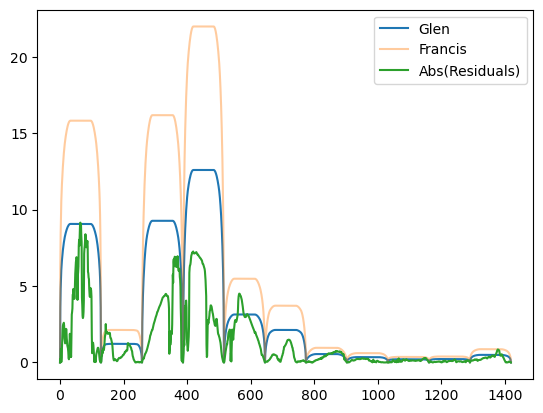

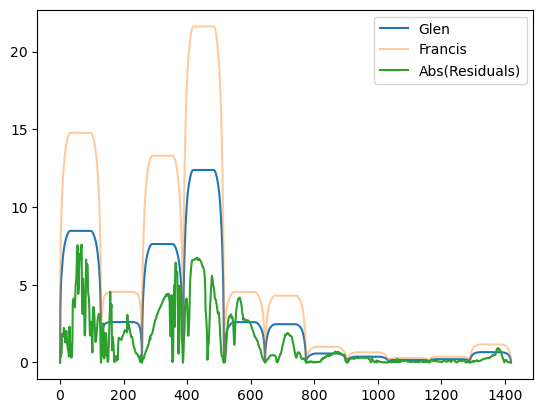

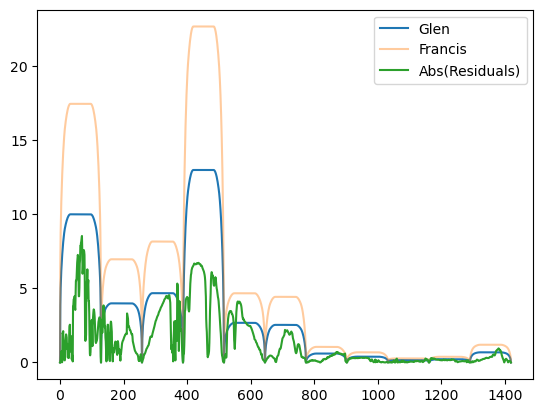

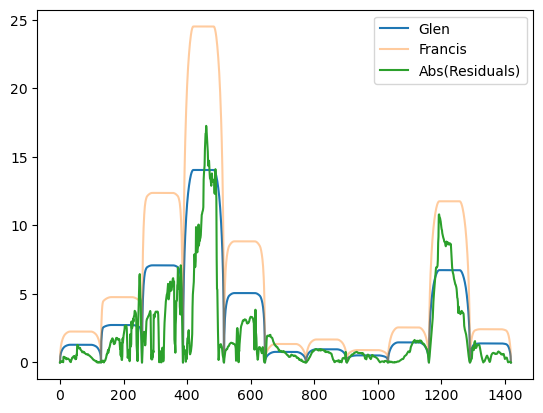

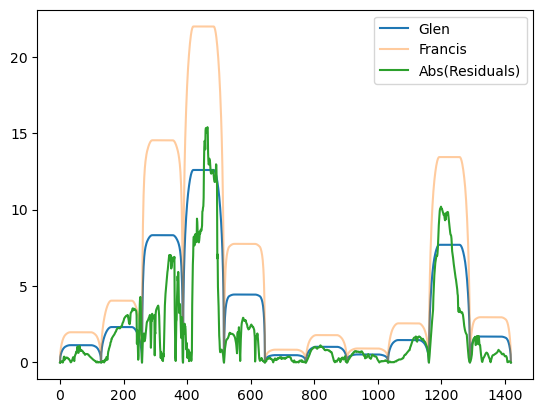

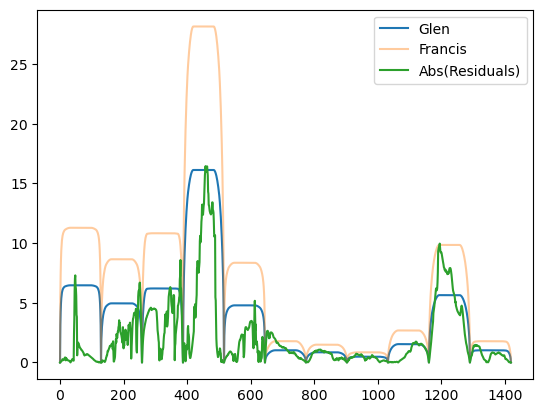

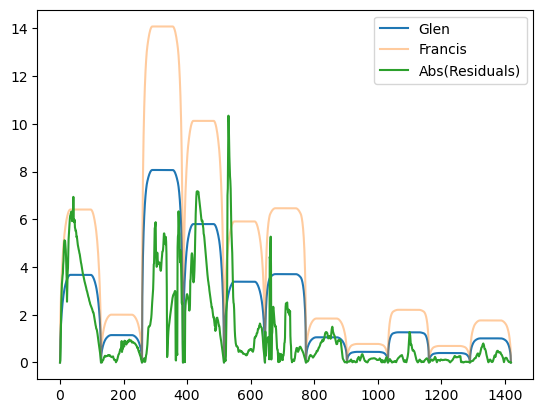

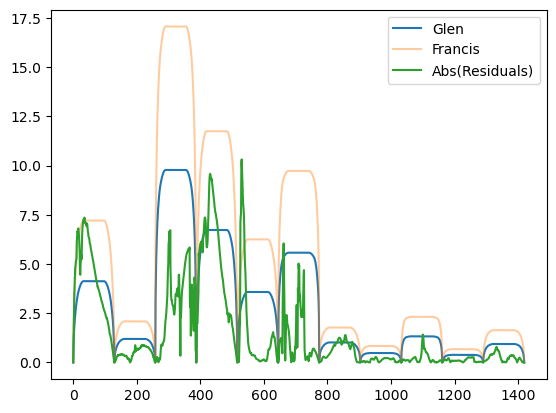

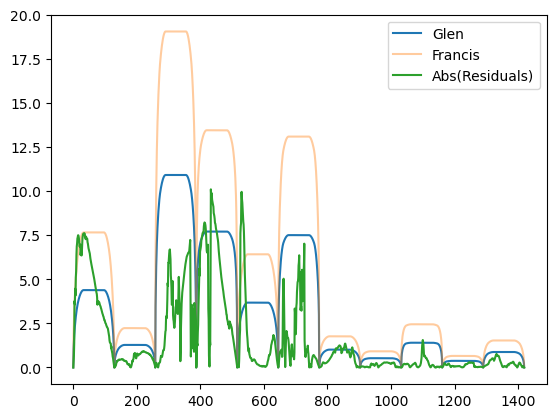

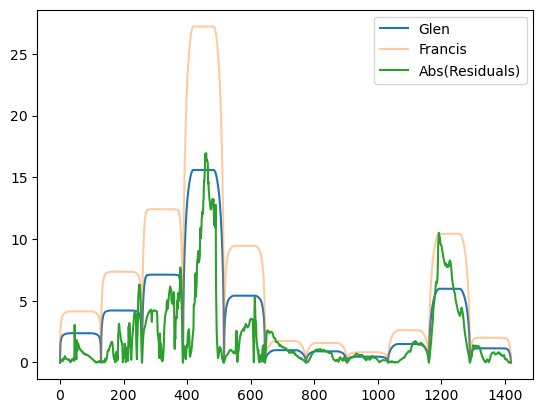

In [174]:
rows = [129, 125, 123, 653, 651, 656, 959, 960, 961, 655]
for row in rows:
    plt.figure()
    plt.plot(output[row], label='Glen')
    plt.plot(output2[row], '-', label='Francis', alpha=0.4)
    # plt.xlim(col_range[0]-10, col_range[1]+10)
    plt.plot(np.abs(residuals[row]), label='Abs(Residuals)')
    # plt.plot(np.abs(output), label='Abs(Residuals)')
    # plt.plot(output2, label='glen')
    # plt.vlines(column_indices, colors='gray', ymin=np.nanmin(output), ymax=np.nanmax(np.abs(output)), alpha=0.4)
    plt.legend()

In [280]:
files_folder = Path("seafloor_files") 
files_list = [(str(file.stem), str(file.name)) for file in files_folder.iterdir() if file.is_file()]
filename_selector = widgets.Dropdown(
    options=files_list,
    description='Surface:',
    disabled=False,
)

fft_methods_list = ['amplitude', 'density_trap', 'density_sum', 'spectrum']
fft_selector = widgets.Dropdown(
    options=fft_methods_list,
    description='PSD Method:',
    disabled=False,
    positioning='top'
)

window_size_selector = widgets.SelectionSlider(
    options=[1, 2, 4],
    description='Multiple',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

linespacing_selector = widgets.SelectionSlider(
    options=[32, 64, 128, 256, 512, 1024],
    description='Linespacing',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

row_selector = widgets.IntSlider(
    step=1,
    max=1000,
    value=400,
    description='Row Number:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

multiple_selector = widgets.SelectionSlider(
    options=[1, 2, 4],
    value=1,
    description='Multiple: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)


linespacing_selector = widgets.SelectionSlider(
    options=[32, 64, 128, 256, 512, 1024],
    value=512,
    description='Linespacing (m): ',
    style={'description_width': 'initial'},
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

range_selector = widgets.IntRangeSlider(
    value=[0, 2],
    min=0,
    max=2,
    step=1,
    description='Column Ranges',
    style={'description_width': 'initial'},
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)


# multiple_selector = widgets.RadioButtons(
#     options=[1, 2, 4],
# #    value='pineapple', # Defaults to 'pineapple'
# #    layout={'width': 'max-content'}, # If the items' names are long
#     description='Multiple',
#     disabled=False
# )

# items_layout = widgets.Layout( width='auto')     # override the default width of the button to 'auto' to let the button grow

# box_layout = widgets.Layout(display='flex',
#                     flex_flow='row', 
#                     align_items='stretch', 
#                     border='solid',
#                     width='50%')

# items = [filename_selector, fft_selector]
# box = widgets.Box(children=items, layout=box_layout)
# box  

@widgets.interact(filename=filename_selector, 
                  bathy_row=row_selector, 
                  multiple=multiple_selector, 
                  linespacing=linespacing_selector,
                  column_range=range_selector,
                  fft_method=fft_selector) 
def visualize_file(filename, bathy_row, multiple, linespacing, column_range, fft_method):
    bathy_file = BathyObject(filename=filename)
    row_selector.max = bathy_file.number_of_rows - 1
    current_row = bathy_row
    
    # VISUALIZE BATHYMETRY AND ROW NUMBER
    fig = plt.figure(figsize=(20, 10))
    ax1 = plt.subplot(231)
    im = ax1.imshow(bathy_file.bathy_data, cmap='terrain', aspect='equal')
    fig.colorbar(im, label='Depth (m)')
    locs = ax1.get_xticks()
    ax1.set_xticks(locs)
    ax1.set_xticklabels([int(x * bathy_file.resolution) for x in locs])
    locs = ax1.get_yticks()
    ax1.set_yticks(locs)
    ax1.set_yticklabels([int(y * bathy_file.resolution) for y in locs])
    # ax1.set_xticks(ax1.get_xticks())
    # ax1.set_yticks(ax1.get_yticks())
    # ax1.set_xticklabels([f"{x * bathy_file.resolution:.0f}" for x in ax1.get_xticks()])
    # ax1.set_yticklabels([f"{y * bathy_file.resolution:.0f}" for y in ax1.get_yticks()])
    ax1.tick_params(axis='x', labelrotation=90)
    ax1.set_xlabel("West-East (m)")
    ax1.set_ylabel("North-South (m)")
    ax1.set_title(f"""
                Surface:{bathy_file.path.stem} at {bathy_file.resolution}m resolution
                Dimensions: {bathy_file.shape[0] * bathy_file.resolution/1000}km by {bathy_file.shape[1] * bathy_file.resolution/1000}km
                    """)
    plt.plot([0, bathy_file.number_of_columns-1], [current_row, current_row], color='red', linewidth=2)
    
    
    updated_line_spacings = [32, 64, 128, 256, 512, 1024]
    multiples = [1, 2, 4]
    multiple_selector.options = multiples
    linespacing_selector.options = updated_line_spacings
    Surface_Simulation.linespacing_meters_list = updated_line_spacings
    Surface_Simulation.multiplier_list = multiples
    current_surface = BathyObject(filename)
    sampling_columns = Surface_Simulation.determine_columns(bathy_object=current_surface, linespacing_meters=linespacing, max_multiple=np.max(multiple))
    range_selector.max = len(sampling_columns) 
    row_depth = bathy_file.bathy_data[current_row]
    residual_dict = Surface_Simulation.compute_residual_error_by_row(row_depth, sampling_columns)
    residual_row = residual_dict['residual_row']
    interpolated_row = residual_dict['interpolated_row']
    
    # PLOT ROW NUMBER AND INTERPOLATED
    ax2 = plt.subplot(232)
    ax2.plot(row_depth, label="Raw Depth")
    ax2.plot(sampling_columns, row_depth[sampling_columns], 'ro')
    ax2.plot(interpolated_row, label="Interpolated", color='orange')
    ax2.vlines(sampling_columns, ymin=np.min(row_depth),ymax=np.max(row_depth), color='gray', linestyle='--', alpha=0.2)
    locs = ax2.get_xticks()
    ax2.set_xticks(locs)
    ax2.set_xticklabels([int(x * bathy_file.resolution) for x in locs])
    locs = ax2.get_yticks()
    ax2.set_yticks(locs)
    # ax2.set_yticklabels([int(y * bathy_file.resolution) for y in locs])
    ax2.set_xlim(left=sampling_columns[column_range[0]], right=sampling_columns[column_range[1]-1])
    ax2.set_title(f"Row Number: {bathy_row}")
    ax2.set_xlabel("West-East (m)")
    ax2.set_ylabel("Depth (m)")
    plt.legend()
    
    # PLOT RESIDUAL AND WINDOWED VERSION
    # windowed = 
    ax3 = plt.subplot(233)
    ax3.plot(residual_row, label='Residual', color='brown')
    ax3.vlines(sampling_columns, ymin=np.nanmin(residual_row),ymax=np.nanmax(residual_row), color='gray', linestyle='--', alpha=0.2)
    ax3.hlines(y=0, xmin=0, xmax=len(residual_row), color='gray', linestyle='--', alpha=0.2)
    locs = ax3.get_xticks()
    ax3.set_xticks(locs)
    ax3.set_xticklabels([int(x * bathy_file.resolution) for x in locs])
    locs = ax3.get_yticks()
    ax3.set_yticks(locs)
    ax3.set_yticklabels([y * bathy_file.resolution for y in locs])
    ax3.set_ylabel("Residual Error (m)")
    ax3.set_xlabel("West-East (m)")
    ax3.set_title(f"Residual at Row {bathy_row}")
    ax3.set_xlim(left=sampling_columns[column_range[0]], right=sampling_columns[column_range[1]-1])
    plt.legend()
    
    
    # PLOT INPUT TO FFT
    ax4 = plt.subplot(235)
    ax4.plot(np.abs(residual_row), label='Residual', color='brown')
    
    fft_dict = Surface_Simulation.compute_fft_uncertainty_by_row(residual_row, sampling_columns, multiplier=multiple, fft_method=fft_method, resolution=int(seafloor_object.resolution))
    ax4.plot(fft_dict['uncertainty_row'], '--', label=f"uncertainty: {fft_method}")
    
    ax4.vlines(sampling_columns, ymin=np.nanmin(residual_row),ymax=np.nanmax(residual_row), color='gray', linestyle='--', alpha=0.2)
    ax4.hlines(y=0, xmin=0, xmax=len(residual_row), color='gray', linestyle='--', alpha=0.2)
    locs = ax4.get_xticks()
    ax4.set_xticks(locs)
    ax4.set_xticklabels([int(x * bathy_file.resolution) for x in locs])
    locs = ax4.get_yticks()
    ax4.set_yticks(locs)
    # ax4.set_yticklabels([y * bathy_file.resolution for y in locs])
    ax4.set_ylabel("Residual Error (m)- Absolute Value")
    ax4.set_xlabel("West-East (m)")
    ax4.set_title(f"Residual at Row {bathy_row}")
    ax4.set_xlim(left=sampling_columns[column_range[0]], right=sampling_columns[column_range[1]-1])
    plt.legend()
    
    
# def plot_uncertainties()
    
    
    
      
# widgets.interact(visualize_file, filename=filename_selector)


interactive(children=(Dropdown(description='Surface:', options=(('BlueTopo', 'BlueTopo.tiff'), ('BlueTopo_US5N…

In [ ]:


def visualize_row()

widgets.interact(visualize_row, filename=filename_selector, multiple=window_size_selector)
    

'Slopey_MA.tif'